In [ ]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

_EPS = 1e-12

In [ ]:
def cal_neff(abs_vals, beta: float) -> int:
    w = abs_vals
    L1 = w.sum() + _EPS
    p = w / L1
    neff = 1.0 / (np.sum(p * p) + _EPS)
    k = int(np.floor(beta * neff))
    return max(1, min(k, abs_vals.size))

def EMP_channel(channel: np.ndarray, beta: float):
    x = channel.astype(np.float32)
    mu = x.mean()
    r = (x - mu).ravel()
    abs_r = np.abs(r)

    k = cal_neff(abs_r, beta=beta)
    #print(k)
    if k < r.size:
        idx = np.argpartition(abs_r, -k)[-k:]
        y = np.zeros_like(r)
        y[idx] = r[idx]
    else:
        y = r.copy()

    processed = y.reshape(x.shape) + mu
    return processed, k

def EMP_patch(patch: np.ndarray, beta: float, q: float = 1.0):
    x = patch.astype(np.float32)
    mu = x.mean()
    r = (x - mu).ravel()
    abs_r = np.abs(r)

    k = cal_neff(abs_r, beta=beta)
    k = max(1, min(k, r.size))

    if 0 < k < r.size:
        idx = np.argpartition(abs_r, -k)[-k:]
        y = np.zeros_like(r)
        y[idx] = r[idx]
    elif k >= r.size:
        y = r.copy()
    else:
        y = np.zeros_like(r)

    processed = y.reshape(x.shape) + mu
    return processed, k

In [ ]:
def calculate_metrics(original, processed):
    original = np.clip(original, 0, 255).astype(np.uint8)
    processed = np.clip(processed, 0, 255).astype(np.uint8)
    psnr_value = psnr(original, processed, data_range=255)
    if original.ndim == 3:
        ssim_value = ssim(original, processed, channel_axis=2, data_range=255)
    else:
        ssim_value = ssim(original, processed, data_range=255)
    return {'psnr': psnr_value, 'ssim': ssim_value}

In [ ]:
def EMP_pruning(
    image_path_or_array,
    save_path=None,
    pixel_beta: float = 1.0,
    patch_beta: float = 1.0,
    patch_size: int = 4,
    dpi: int = 150
):
    # Load + normalize to RGB
    if isinstance(image_path_or_array, str):
        img = Image.open(image_path_or_array)
        name = Path(image_path_or_array).stem
        original = np.array(img)
    else:
        name = "image"
        original = np.array(image_path_or_array)

    h, w, c = original.shape
    total_pixels = h * w * c

    # ----- Pixel-wise image and sparsity (compute kept counts during a pass)
    arr = original.astype(np.float32)
    r_proc, k_r = EMP_channel(arr[:, :, 0], beta=pixel_beta)
    g_proc, k_g = EMP_channel(arr[:, :, 1], beta=pixel_beta)
    b_proc, k_b = EMP_channel(arr[:, :, 2], beta=pixel_beta)
    pix_img = np.stack([r_proc, g_proc, b_proc], axis=2)
    pix_img = np.clip(pix_img, 0, 255).astype(np.uint8)
    pix_kept_total = int(k_r + k_g + k_b)
    pix_fraction_kept = pix_kept_total / total_pixels
    pix_sparsity = 1.0 - pix_fraction_kept
    pix_metrics = calculate_metrics(original, pix_img)

    # ----- Patch-wise image and sparsity
    arr = original.astype(np.float32)
    h, w, c = arr.shape
    patch_img_f = np.zeros_like(arr)
    kept_sum = 0
    for ch in range(c):
        channel = arr[:, :, ch]
        channel_out = np.zeros_like(channel)
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                i_end = min(i + patch_size, h)
                j_end = min(j + patch_size, w)
                patch = channel[i:i_end, j:j_end]
                patch_proc, k_patch = EMP_patch(patch, beta=patch_beta)
                kept_sum += int(k_patch)
                channel_out[i:i_end, j:j_end] = patch_proc
        patch_img_f[:, :, ch] = channel_out

    patch_img = np.clip(patch_img_f, 0, 255).astype(np.uint8)
    patch_fraction_kept = kept_sum / total_pixels
    patch_sparsity = 1.0 - patch_fraction_kept
    patch_metrics = calculate_metrics(original, patch_img)

    # ----- Plot 1×3
    plt.figure(figsize=(18, 6))
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(original.astype(np.uint8))
    ax1.set_title('Original', fontsize=14, fontweight='bold')
    ax1.axis('off')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(pix_img)
    ax2.set_title(
        f'EMP Pixel-wise\nPSNR: {pix_metrics["psnr"]:.1f} dB'
        f'\nSSIM: {pix_metrics["ssim"]:.3f}'
        f'\nSparsity: {pix_sparsity:.3f}',
        fontsize=12
    )
    ax2.axis('off')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(patch_img)
    ax3.set_title(
        f'EMP Patch-wise\nPSNR: {patch_metrics["psnr"]:.1f} dB'
        f'\nSSIM: {patch_metrics["ssim"]:.3f}'
        f'\nSparsity: {patch_sparsity:.3f}',
        fontsize=12
    )
    ax3.axis('off')

    plt.tight_layout()
    if save_path is not None:
        os.makedirs(Path(save_path).parent, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

    return {
        'pixel': {
            'image': pix_img,
            'metrics': pix_metrics,
            'sparsity': pix_sparsity,
            'kept': int(pix_kept_total),
            'total': int(total_pixels)
        },
        'patch_rgb': {
            'image': patch_img,
            'metrics': patch_metrics,
            'sparsity': patch_sparsity,
            'kept': int(kept_sum),
            'total': int(total_pixels)
        }
    }


17646958
17492626
17611662


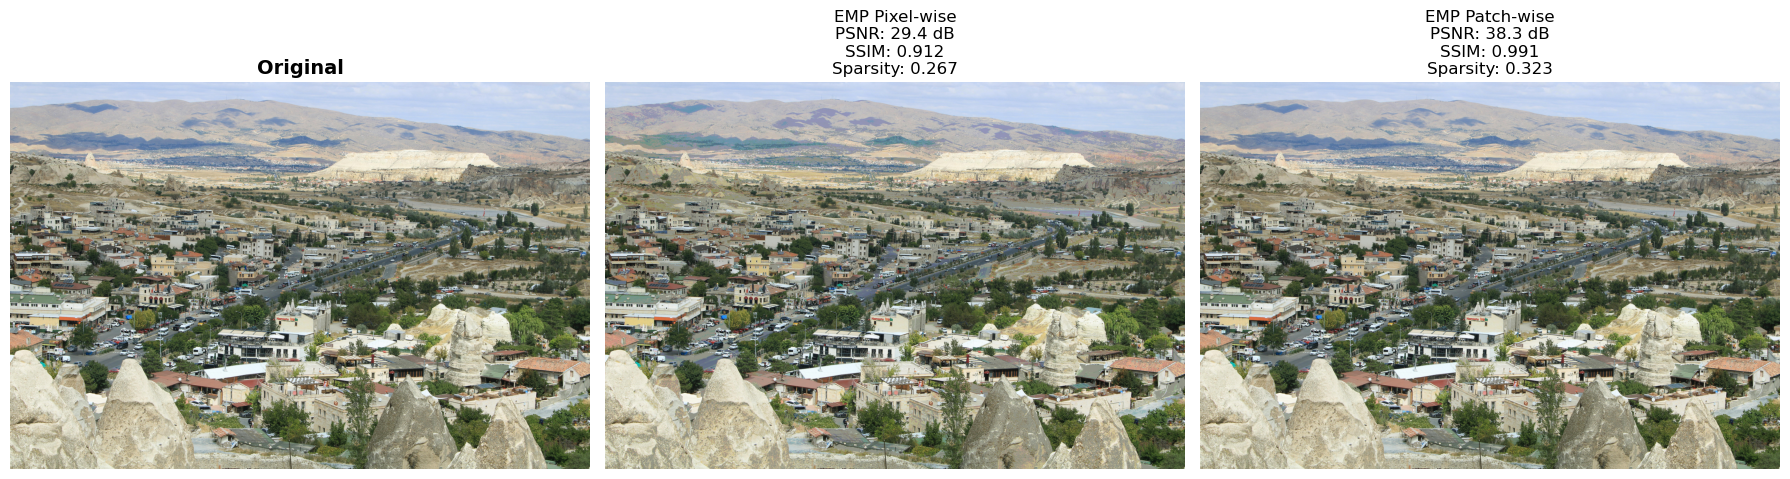

{'pixel': {'image': array([[[188, 205, 231],
          [188, 205, 231],
          [188, 205, 231],
          ...,
          [202, 214, 236],
          [202, 214, 236],
          [202, 214, 236]],
  
         [[188, 205, 231],
          [188, 205, 231],
          [188, 205, 231],
          ...,
          [202, 214, 236],
          [202, 214, 236],
          [202, 214, 236]],
  
         [[188, 205, 231],
          [188, 205, 231],
          [188, 205, 231],
          ...,
          [202, 214, 236],
          [202, 214, 236],
          [202, 214, 236]],
  
         ...,
  
         [[182, 148, 135],
          [146, 148, 135],
          [146, 148, 135],
          ...,
          [202, 206, 191],
          [209, 211, 197],
          [212, 214, 200]],
  
         [[184, 178, 135],
          [146, 148, 135],
          [146, 148, 106],
          ...,
          [197, 201, 184],
          [204, 207, 190],
          [207, 210, 193]],
  
         [[189, 181, 135],
          [146, 148, 135],
      

In [8]:
EMP_pruning('figures/city.jpg', 'figures/result_city.png', 1, 1, 4, 150)